# Ordering of Divergences

In [1]:
import numpy as np

import importlib
import jax
import jax.numpy as jnp
from jax import jit, grad, random
import optax

import numpyro
import numpyro.distributions as dist

import gsmvi
from gsmvi.bbvi import ADVI


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [18]:
# Adjust address to your setting
exec(open('/mnt/home/cmargossian/Code/divergence_order/GSM-VI/gsmvi/fgvi.py').read())
exec(open('/mnt/home/cmargossian/Code/divergence_order/GSM-VI/gsmvi/factorized_bam.py').read())

### Normal target   

In [1554]:
# Function to check if a matrix is positive-definite
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [1555]:
def setup_model(D=10, cov_diagonal=False, standardized=True):
    # setup a Gaussian target distribution
    mean = np.zeros(D)
    L = np.random.normal(size = D**2).reshape(D, D)
    cov = np.matmul(L, L.T) + np.eye(D)*1e-3

    if cov_diagonal:
        cov = np.eye(D) * cov.diagonal()
    
    if standardized:
        for i in range(D):
            for j in range(i):
                cov[i,j] = cov[i,j] / np.sqrt(cov[i, i] * cov[j, j])
                cov[j,i] = cov[i,j] 
        np.fill_diagonal(cov, np.ones(D))

    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: model.log_prob(x))
    lp_sum = jit(lambda x: jnp.sum(model.log_prob(x)))
    # lp_g = jit(grad(lp, argnums=0))
    lp_g = jax.vmap(grad(lp, argnums=0))

    return model, mean, cov, lp_sum, lp, lp_g

In [1556]:
D = 10
model, mean, cov, lp_sum, lp, lp_g = setup_model(D=D)

lr = 1e-2  # starting learning rate
opt = optax.adam(learning_rate=lr)


key = random.PRNGKey(1984)
mean_init = np.zeros(D)  # np.ones(D) # * 100
niter = 500
batch_size = 10**5
# For less conventional divergences, it pays off to have a large batch size and
# number of iterations

# Exponential decay of the learning rate.
scheduler = optax.cosine_onecycle_schedule(
    transition_steps = niter // 10, peak_value = lr
)


### Gaussian VI

In [1287]:
advi = ADVI(D=D, lp=lp)

mean_fit, cov_fit, losses = advi.fit(key, niter=niter, batch_size=batch_size,
                                        opt=opt, mean=mean_init)


Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500


[ 4.5410337  6.6593103 -0.5196914  7.879097   7.9639854]
[0.98343559 1.00436568 0.99228825 0.97272203 1.01801999]


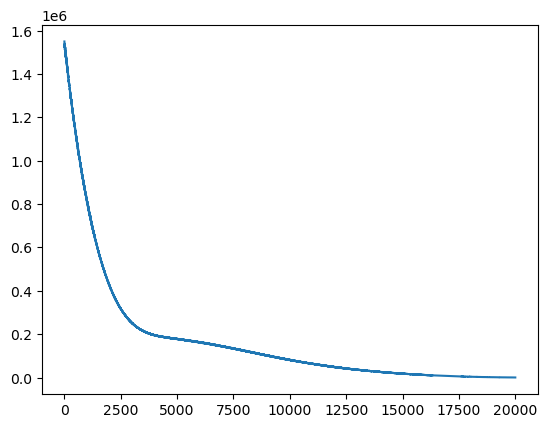

In [27]:
print(mean_fit)
print(cov_fit.diagonal() / cov.diagonal())

plt.plot(losses)

### Factorized Gaussian VI (FG-VI)

In [1557]:
fg_advi = FG_ADVI(D, lp)

# niter = 1000
# batch_size = 64
key = random.PRNGKey(1954)
mean_init = np.ones(D)

mean_fit, cov_fit, losses = fg_advi.fit(key, niter=niter, batch_size=batch_size,
                                        opt=opt, mean=mean_init)

Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500


1.017140256820648


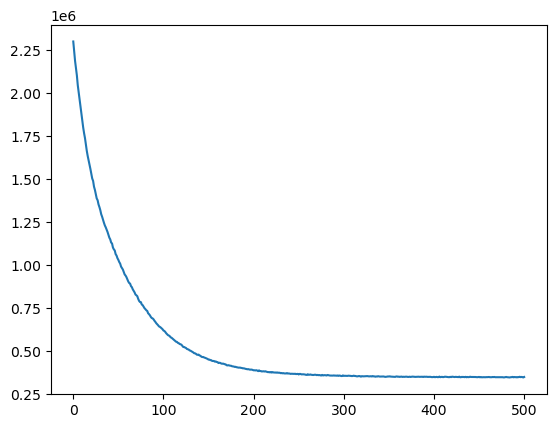

In [1453]:
cov_fit_th = 1 / np.linalg.inv(cov).diagonal()

# print(mean_fit)
print(np.mean(cov_fit / cov_fit_th))

plt.plot(losses)

In [1454]:
exec(open('/mnt/home/cmargossian/Code/divergence_order/GSM-VI/gsmvi/fgvi.py').read())

In [1455]:
alpha = 0.1
# batch_size = 4096
fg_alpha = FG_alpha(D, lp, alpha)

alpha2 = 0.2
fg_alpha2 = FG_alpha(D, lp, alpha2)

alpha3 = 0.01
fg_alpha3 = FG_alpha(D, lp, alpha3)

alpha4 = 0.5
fg_alpha4 = FG_alpha(D, lp, alpha4)

key = random.PRNGKey(1958)

In [1456]:
mean_fit_alpha, cov_fit_alpha, losses_alpha =\
    fg_alpha.fit(key, niter=niter, batch_size=batch_size, opt=opt, mean=mean_init,
                 cov_diag=cov.diagonal())

mean_fit_alpha2, cov_fit_alpha2, losses_alpha2 =\
   fg_alpha.fit(key=random.PRNGKey(2003), niter=niter, batch_size=batch_size, opt=opt, mean=mean_init,
                 cov_diag=None) 

mean_fit_alpha3, cov_fit_alpha3, losses_alpha3 =\
    fg_alpha2.fit(key=random.PRNGKey(2003), niter=niter, batch_size=batch_size, opt=opt, mean=mean_init,
                 cov_diag=None)

mean_fit_alpha4, cov_fit_alpha4, losses_alpha4 =\
    fg_alpha3.fit(key=random.PRNGKey(2003), niter=niter, batch_size=batch_size, opt=opt, mean=mean_init,
                 cov_diag=None)

mean_fit_alpha5, cov_fit_alpha5, losses_alpha5 =\
    fg_alpha4.fit(key=random.PRNGKey(2003), niter=niter, batch_size=batch_size, opt=opt, mean=mean_init,
                 cov_diag=None)


Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500
Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500
Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500
Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500
Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iterati

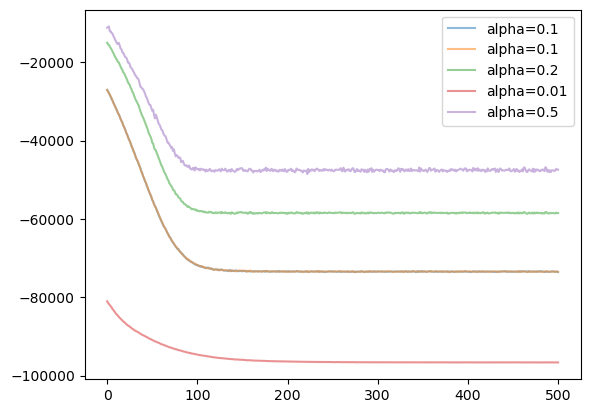

In [1457]:
plt.plot(losses_alpha, alpha=0.5, label = "alpha=" + str(alpha))
plt.plot(losses_alpha2, alpha=0.5, label = "alpha=" + str(alpha))
plt.plot(losses_alpha3, alpha=0.5, label = "alpha=" + str(alpha2))
plt.plot(losses_alpha4, alpha=0.5, label = "alpha=" + str(alpha3))
plt.plot(losses_alpha5, alpha=0.5, label = "alpha=" + str(alpha4))
# plt.plot(losses, alpha = 0.5, label = "KL(q||p)")

plt.legend(loc="best")

### Factorized BaM!

In [1459]:
batch_size = 10**4

In [ ]:
fg_bam = FG_BAM(D, lp, lp_g)

niter = 500
def regf(i):
    return 1 # 100 # / (1 + i)  #000 #/ (1 + i)

In [1465]:
mean_fit_bam, cov_fit_bam , mean_all, cov_all =\
    fg_bam.fit(key, regf, batch_size=batch_size, niter=niter, cov_diag=cov.diagonal(),
               mean=np.ones(D) * 10)

Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500


In [1466]:
print(mean_fit_bam)

print(cov_fit_bam)

print(cov.diagonal())

[ 8.0397539e-04 -7.5048703e-04 -6.8886620e-05 -5.3314265e-04
 -1.6566119e-04  9.1629138e-04  1.2261298e-03  3.0875852e-04
 -5.9596496e-04  9.6347043e-04]
[0.52693003 0.66779125 0.11263881 0.11272223 0.27156484 0.13395728
 0.28403693 0.08633016 0.21566133 0.14918226]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


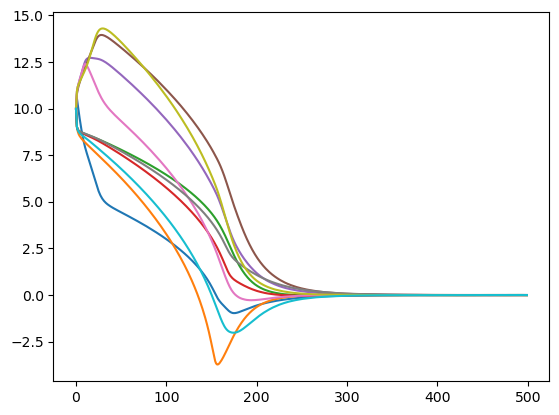

In [1467]:
plt.plot(mean_all)

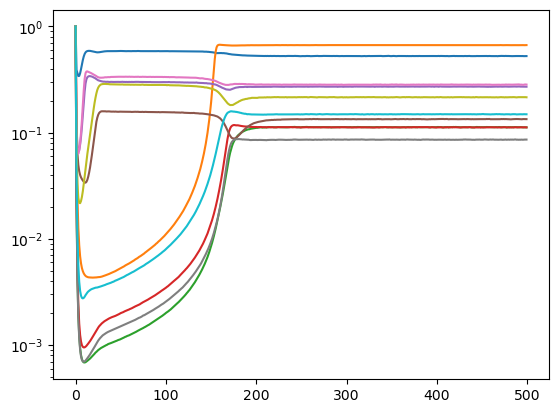

In [1469]:
plt.plot(cov_all)
plt.yscale("log")

### Compare estimated variances

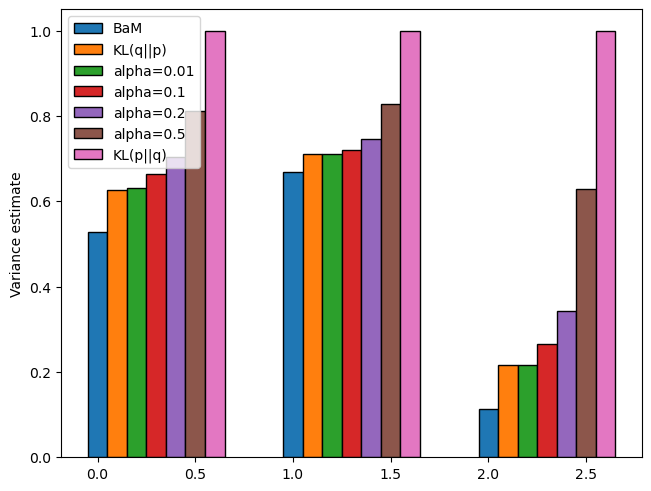

In [1470]:
# ToDo: normalize all variances by true variance

n_plot=3

cov_estimates = {
    "BaM": cov_fit_bam[0:n_plot],
    "KL(q||p)": cov_fit[0:n_plot],
    "alpha=" + str(alpha3): cov_fit_alpha4[0:n_plot],
    "alpha=" + str(alpha): cov_fit_alpha[0:n_plot],
    "alpha=" + str(alpha2): cov_fit_alpha3[0:n_plot],
    "alpha=" + str(alpha4): cov_fit_alpha5[0:n_plot],
    "KL(p||q)": cov.diagonal()[0:n_plot]
}

x = np.arange(n_plot)  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in cov_estimates.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, edgecolor='black')
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Variance estimate')
# ax.set_title('Penguin attributes by species')
# ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=1)
# ax.set_ylim(0, 250)

plt.show()

In [1471]:
# print(mean_fit_alpha)
# print(mean_fit_alpha2)

print(alpha, cov_fit_alpha[1:5])
print(alpha, cov_fit_alpha2[1:5])
print(alpha2, cov_fit_alpha3[1:5])
print(alpha4, cov_fit_alpha5[1:5])
print(alpha3, cov_fit_alpha4[1:5])
print(0, cov_fit[1:5])
print(cov.diagonal()[1:5])


0.1 [0.7201259  0.26644894 0.24450026 0.43309602]
0.1 [0.72179335 0.26667792 0.24464178 0.43367723]
0.2 [0.74510556 0.34274796 0.31218797 0.48647627]
0.5 [0.8284502  0.62832224 0.5961388  0.6613332 ]
0.01 [0.71118355 0.2170845  0.20312916 0.3899692 ]
0 [0.71019614 0.21522556 0.2025373  0.3858692 ]
[1. 1. 1. 1.]


In [36]:
def entropy(cov, is_diag=False):
    D = cov.shape[0]
    if is_diag:
       log_det_cov = np.sum(np.log(cov))
    else:
        _, log_det_cov = np.linalg.slogdet(cov)
    
    return 0.5 * log_det_cov + 0.5 * D * np.log(2 * np.pi * np.e)

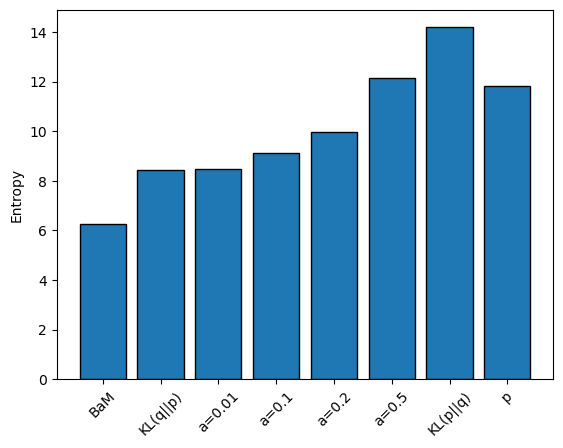

In [1492]:
cov_estimates = {
    "BaM": entropy(cov_fit_bam, is_diag=True),
    "KL(q||p)": entropy(cov_fit, is_diag=True),
    "alpha=" + str(alpha3): entropy(cov_fit_alpha4, is_diag=True),
    "alpha=" + str(alpha): entropy(cov_fit_alpha, is_diag=True),
    "alpha=" + str(alpha2): entropy(cov_fit_alpha3, is_diag=True),
    "alpha=" + str(alpha4): entropy(cov_fit_alpha5, is_diag=True),
    "KL(p||q)": entropy(cov.diagonal(), is_diag=True),
    "|Sigma|": entropy(cov)
}

algorithm = ["BaM", "KL(q||p)", "a=" + str(alpha3), "a=" + str(alpha), "a=" + str(alpha2),
             "a=" + str(alpha4), "KL(p||q)", "p"]

entropy_estimate = [entropy(cov_fit_bam, is_diag=True),
                    entropy(cov_fit, is_diag=True),
                    entropy(cov_fit_alpha4, is_diag=True),
                    entropy(cov_fit_alpha, is_diag=True),
                    entropy(cov_fit_alpha3, is_diag=True),
                    entropy(cov_fit_alpha5, is_diag=True),
                    entropy(cov.diagonal(), is_diag=True),
                    entropy(cov)]


fig, ax = plt.subplots()
bar_container = ax.bar(algorithm, entropy_estimate, edgecolor='black')
ax.set(ylabel="Entropy")
ax.tick_params(axis='x', labelrotation=45)


### Non-Gaussian target

In [5]:
# Adjust font size for figures
font = {'size'   : 15}
plt.rc('font', **font)

# plt.rcParams.update({
#     "text.usetex": True,
# })

In [6]:
from inference_gym import using_jax as gym
import tensorflow_probability as tfp 

2024-03-11 12:44:38.798203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [99]:
# Model from the inference gym
model_name = "Eight Schools"
# options: Rosenbrock, German Credit, Eight Schools, Radon Effect,
#          Gaussian, sinh-arcsinh, Stochastic Volatility

if model_name == "Rosenbrock":
    target = gym.targets.VectorModel(gym.targets.Banana(),
                                    flatten_sample_transformations=True)

if model_name == "German Credit":
    # NOTE: alpha divergence optimization is unstable for this model
    target = gym.targets.VectorModel(gym.targets.GermanCreditNumericLogisticRegression(),
                                     flatten_sample_transformations=True)

if model_name == "Eight Schools":
    target = gym.targets.VectorModel(gym.targets.EightSchools(),
                                    flatten_sample_transformations=True)
if model_name == "Radon Effect":
    target = gym.targets.VectorModel(gym.targets.RadonContextualEffectsMinnesota(),
                                     flatten_sample_transformations=True)
    
if model_name == "Stochastic Volatility":
    target = gym.targets.VectorModel(gym.targets.StochasticVolatilitySP500Small(),
                                     flatten_sample_transformations=True)


/mnt/home/cmargossian/Code/nested-rhat/virenv/nRhatVirenv/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


In [100]:

def target_log_prob_fn(x):
  """Unnormalized, unconstrained target density.

  This is a thin wrapper that applies the default bijectors so that we can
  ignore any constraints.
  """
  y = target.default_event_space_bijector(x)
  fldj = target.default_event_space_bijector.forward_log_det_jacobian(x)
  return target.unnormalized_log_prob(y) + fldj


if model_name in ["Rosenbrock", "German Credit", "Eight Schools", "Radon Effect",
                  "Stochastic Volatility"]:
  D = target.event_shape[0]
  lp = jit(lambda x: target_log_prob_fn(x))
  lp_sum = jit(lambda x: jnp.sum(model.log_prob(x)))
  lp_g = jax.vmap(grad(lp, argnums=0))

  mean_est = target.sample_transformations['identity'].ground_truth_mean
  var_est = target.sample_transformations['identity'].ground_truth_standard_deviation**2
else:
  if model_name == "Gaussian":
    D=10
    model, mean, cov, lp_sum, lp, lp_g = setup_model(D=D)

    mean_est = mean
    var_est = cov.diagonal()
  
  if model_name == "sinh-arcsinh":
    D=3
    skew = 1
    tail_weight = 1
    model, mean, scale, lp, lp_g, _samples = setup_sinh_arcsinh_model(D, skew, tail_weight, key)
    
    mean_est = mean
    var_est = scale


In [101]:
niter = 1000
batch_size = 10**4
key = random.PRNGKey(1984)

# Tuning for KL and alpha divergences
lr = 1e-1
opt = optax.adam(learning_rate=lr)

# Tuning for BaM
def regf(i):
    return 1



In [102]:
# Factorized Gaussian VI
fg_advi = FG_ADVI(D, lp)
mean_init = np.ones(D)
cov_init = np.ones(D)

mean_fit, cov_fit, losses = fg_advi.fit(key, niter=niter, batch_size=batch_size, opt=opt)

Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000
Iteration 1000 of 1000


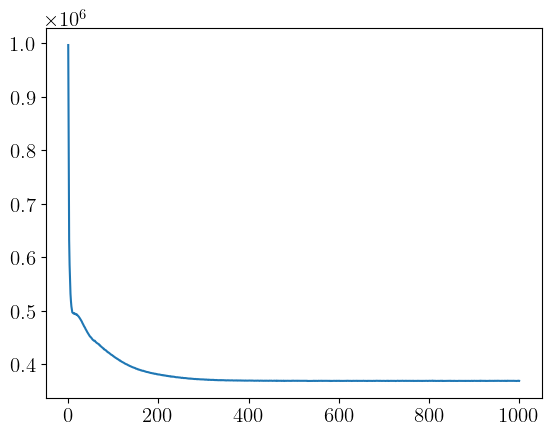

In [103]:
plt.plot(losses)
plt.show()

In [104]:
alpha = 0.1
fg_alpha_01 = FG_alpha(D, lp, alpha)

mean_fit_alpha_01, cov_fit_alpha_01, losses_alpha_01 =\
    fg_alpha_01.fit(key, niter=niter, batch_size=batch_size, opt=opt)

alpha2 = 0.5
fg_alpha_05 = FG_alpha(D, lp, alpha2)
mean_fit_alpha_05, cov_fit_alpha_05, losses_alpha_05 =\
    fg_alpha_05.fit(key, niter=niter, batch_size=batch_size * 10, opt=opt)

# NOTE: values of alpha close to 1 are not stable
# alpha3 = 0.9
# fg_alpha_09 = FG_alpha(D, lp, alpha3)
# mean_fit_alpha_09, cov_fit_alpha_09, losses_alpha_09 =\
#     fg_alpha_09.fit(key, niter=niter, batch_size=batch_size, opt=opt)

Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000
Iteration 1000 of 1000
Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000
Iteration 1000 of 1000


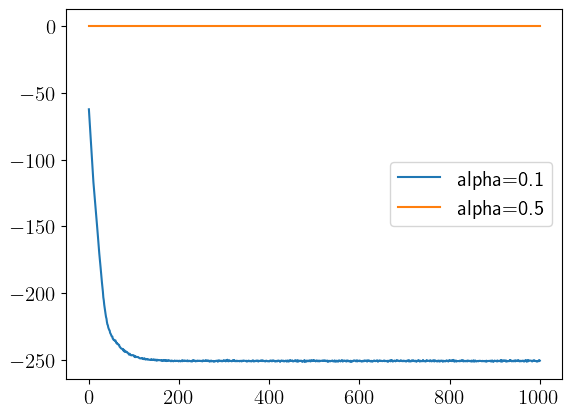

In [105]:
plt.plot(losses_alpha_01, label="alpha=" + str(alpha))
plt.plot(losses_alpha_05, label="alpha=" + str(alpha2))
plt.legend(loc="best")
plt.show()

In [106]:
# Factorized Batch and Match
fg_bam = FG_BAM(D, lp, lp_g)

# NOTE: for certain model, may need to adjust iter to reach convergence.
# e.g. for Radon model, convergence occurs around 2000+ iterations
if model_name == "Radon Effect":
    niter = 10**4

mean_fit_bam, cov_fit_bam, mean_all, cov_all =\
    fg_bam.fit(key, regf, batch_size=batch_size, niter=niter)


Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000


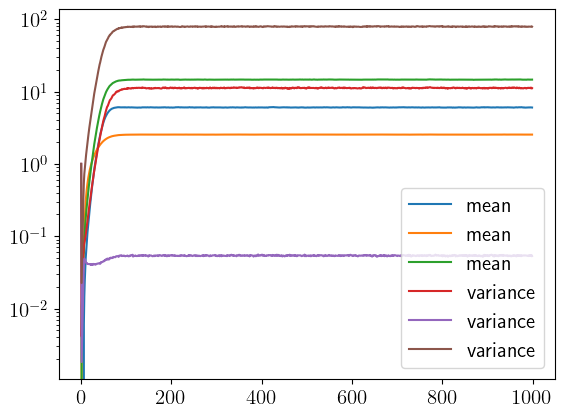

In [107]:
n_plot = 3

plt.plot(mean_all[:, 0:n_plot], label = "mean")
plt.plot(cov_all[:, 0:n_plot], label = "variance")
plt.yscale("log")
plt.legend(loc="best")
plt.show()

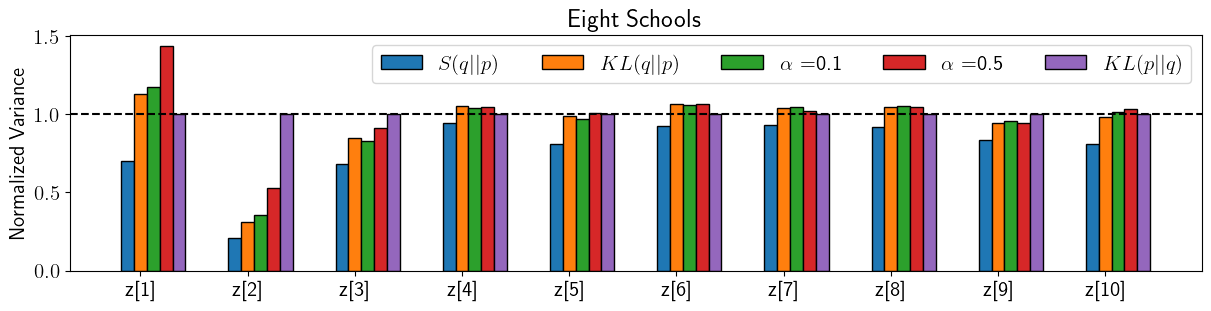

In [115]:
# Compare estimated variances
n_plot = min(10, D)

z = ['']*n_plot
for i in range(n_plot):
    z[i] = "z[" + str(i + 1) + "]"


cov_estimates = {
    "$S(q||p)$": cov_fit_bam[0:n_plot] / var_est[0:n_plot],
    "$KL(q||p)$": cov_fit[0:n_plot] / var_est[0:n_plot],
    r"$\alpha$ =" + str(alpha): cov_fit_alpha_01[0:n_plot] / var_est[0:n_plot],
    r"$\alpha$ =" + str(alpha2): cov_fit_alpha_05[0:n_plot] / var_est[0:n_plot],
    "$KL(p||q)$": var_est[0:n_plot] / var_est[0:n_plot]
}

if model_name in ['German Credit', 'Radon Effect', 'Stochastic Volatility']:
    del cov_estimates[r"$\alpha$ =" + str(alpha)]
    del cov_estimates[r"$\alpha$ =" + str(alpha2)]


x = np.arange(n_plot)
width = 0.12  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 3))
ax.axhline(y = 1, color='black', linestyle="--")

for attribute, measurement in cov_estimates.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, edgecolor='black')
    multiplier += 1

# ax.set_xticklabels(z)

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set(ylabel="Normalized Variance", title=model_name)
ax.legend(loc='best', ncols=5)

ax.set_xticks([r + width for r in range(n_plot)], z)


plt.savefig("/mnt/home/cmargossian/Code/divergence_order/deliv/" +\
            model_name.replace(" ", "") + "_variance.pdf",
            bbox_inches="tight")

plt.show()


In [109]:
# Check if all variances are odered
ordered = True
for d in range(D):
    ordered = (cov_estimates["$S(q||p)$"][d] < cov_estimates["$KL(q||p)$"][d]) and ordered
    ordered = (cov_estimates["$KL(q||p)$"][d] < cov_estimates["$KL(p||q)$"][d]) and ordered

    if model_name not in ['German Credit', 'Radon Effect', 'Stochastic Volatility']:
        ordered = (cov_estimates["$KL(q||p)$"][d] < cov_estimates[r"$\alpha$ =" + str(alpha)][d]) and ordered
        ordered = (cov_estimates[r"$\alpha$ =" + str(alpha)][d] < cov_estimates[r"$\alpha$ =" + str(alpha2)][d]) and ordered
        ordered = (cov_estimates[r"$\alpha$ =" + str(alpha2)][d] < cov_estimates["$KL(p||q)$"][d]) and ordered

print(ordered)


False


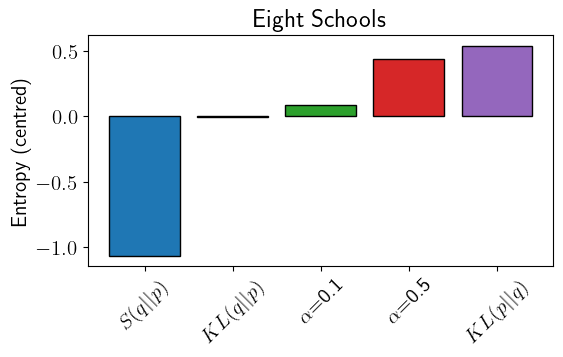

In [110]:
if model_name in ['German Credit', 'Radon Effect', 'Stochastic Volatility']:
    colors = ['tab:blue', 'tab:orange', 'tab:purple']
else:
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

algorithm = ["$S(q||p)$",
             "$KL(q||p)$",
             r"$\alpha$=" + str(alpha),
             r"$\alpha$=" + str(alpha2),
             "$KL(p||q)$"]

entropy_estimate = [entropy(cov_fit_bam, is_diag=True),
                    entropy(cov_fit, is_diag=True),
                    entropy(cov_fit_alpha_01, is_diag=True),
                    entropy(cov_fit_alpha_05, is_diag=True),
                    entropy(var_est, is_diag=True)]

if model_name in ['German Credit', 'Radon Effect', 'Stochastic Volatility']:
    algorithm = [algorithm[i] for i in [0, 1, 4]]
    entropy_estimate = [entropy_estimate[i] for i in [0, 1, 4]]

# Center entropy at average entropy across estimates
entropy_estimate = entropy_estimate - np.mean(entropy_estimate)

fig, ax = plt.subplots(figsize=(6, 3))
bar_container = ax.bar(algorithm, entropy_estimate, edgecolor='black', color = colors)
ax.set(ylabel="Entropy (centred)", title=model_name)
ax.tick_params(axis='x', labelrotation=45)

plt.savefig("/mnt/home/cmargossian/Code/divergence_order/deliv/" +\
            model_name.replace(" ", "") + "_entropy.pdf", bbox_inches="tight")

plt.show()